This notebook runs a local autocorrelation test on both the normalized and unnormalized 311 flooding counts.

In [25]:
import geopandas as gpd
import pandas as pd
import pyproj
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np


pyproj.datadir.set_data_dir('/usr/local/anaconda3/envs/info615/share/proj')


In [26]:
hex_gdf = gpd.read_file('processed_data/complaints_per_10000_people_zero_and_low_pop_outliers_lt10_dropped.geojson')
hex_gdf = hex_gdf.set_crs(epsg=2263, allow_override= True)

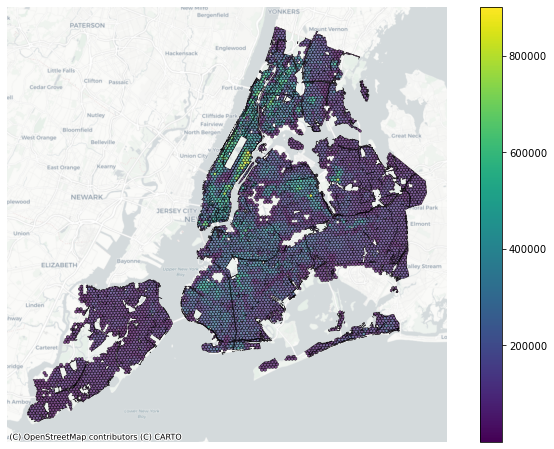

In [27]:
ax = hex_gdf.to_crs(epsg=3857).plot(column = '2020PopEstimate', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8), legend = True)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

In [28]:
#Generate weights and fill islands
w_with_islands = weights.Queen.from_dataframe(hex_gdf)
wKNN = weights.KNN.from_dataframe(hex_gdf, k=6)
w = weights.attach_islands(w_with_islands, wKNN)

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary)
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/_contW_lists.py:26: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy))
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 10 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/usr/lo

There are no disconnected observations (no islands)!


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 7 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [29]:
#Row standardize
w.transform = 'R'

### Run local Moran's I on normalized column

In [30]:
local_moran = esda.moran.Moran_Local(hex_gdf['num_311_complaints_norm'], w)

In [31]:
hex_gdf['local_moran_Is'] = local_moran.Is
hex_gdf['local_moran_p_value'] = local_moran.p_sim
hex_gdf['local_moran_quadrant'] = local_moran.q

In [32]:
alpha = .05
hotspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

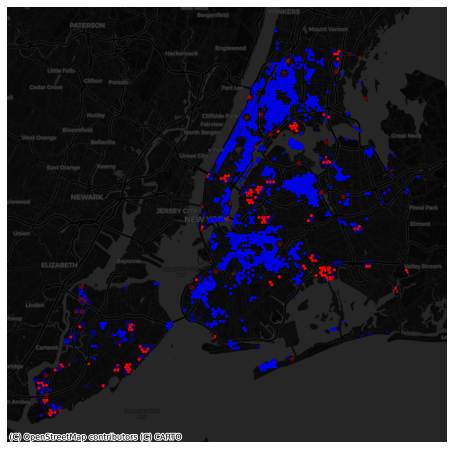

In [33]:
ax = hex_gdf.to_crs(epsg=3857).plot(facecolor='none', alpha=0, figsize = (12,8))
hotspots.to_crs(epsg=3857).plot(color='red', ax=ax, label='Hot Spot')
coldspots.to_crs(epsg=3857).plot(color='blue', ax=ax, label='Cold Spot')
doughnuts.to_crs(epsg=3857).plot(color='blue', alpha=.2, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.to_crs(epsg=3857).plot(color='red', alpha=.2, edgecolor='red', linewidth=2, ax=ax, label='Doughnuts')
cx.add_basemap(ax,source=cx.providers.CartoDB.DarkMatter)
ax.axis('off');


In [34]:
#Add as column for formatting in QGIS
hex_gdf['AutoCor'] = np.nan
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 1), 'AutoCor'] = 'hotspot'
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 3), 'AutoCor'] = 'coldspot'
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 2), 'AutoCor'] = 'doughnut'
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 4), 'AutoCor'] = 'diamond'



### Run local Moran's I on UNnormalized column
OVERWRITES previous results within notebook but writes them to new shapefile for QGIS

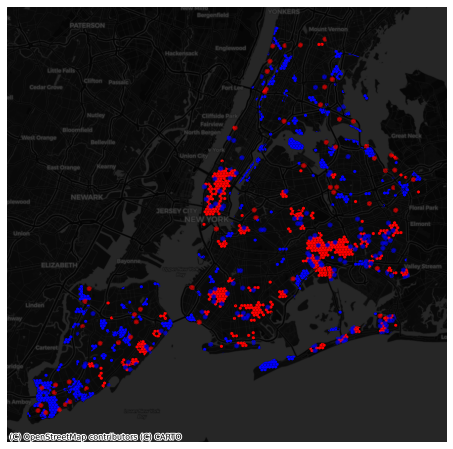

In [35]:
local_moran = esda.moran.Moran_Local(hex_gdf['num_311_complaints'], w)

hex_gdf['local_moran_Is'] = local_moran.Is
hex_gdf['local_moran_p_value'] = local_moran.p_sim
hex_gdf['local_moran_quadrant'] = local_moran.q

alpha = .05
hotspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

ax = hex_gdf.to_crs(epsg=3857).plot(facecolor='none', alpha=0, figsize = (12,8))
hotspots.to_crs(epsg=3857).plot(color='red', ax=ax, label='Hot Spot')
coldspots.to_crs(epsg=3857).plot(color='blue', ax=ax, label='Cold Spot')
doughnuts.to_crs(epsg=3857).plot(color='blue', alpha=.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.to_crs(epsg=3857).plot(color='red', alpha=.5, edgecolor='red', linewidth=2, ax=ax, label='Doughnuts')
cx.add_basemap(ax,source=cx.providers.CartoDB.DarkMatter)
ax.axis('off');

#Add as column for formatting in QGIS
hex_gdf['AutoCorUN'] = np.nan
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 1), 'AutoCorUN'] = 'hotspot'
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 3), 'AutoCorUN'] = 'coldspot'
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 2), 'AutoCorUN'] = 'doughnut'
hex_gdf.loc[(hex_gdf["local_moran_p_value"] < alpha) & (hex_gdf["local_moran_quadrant"] == 4), 'AutoCorUN'] = 'diamond'


In [36]:
#Export for QGIS
hex_gdf.to_file('processed_data/hex_311_complaints_morans_results.shp')

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/x1/y94l059d54s9xkg8km690fd80000gn/T/ipykernel_15502/3394195126.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_gdf.to_file('processed_data/hex_311_complaints_morans_results.shp')
